<a href="https://colab.research.google.com/github/neutrino-dot/yanami_sisters/blob/main/%E5%A3%B0%E3%81%AE%E6%A4%9C%E8%A8%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# yanami pico ver0.0.1

参考文献

[日本語母音のフォルマント周波数の年齢による変化](http://160.12.37.83/proceedings/ASJmeeting/ASJ2006S/pdf/0124_2-4-13.pdf)

[女性声優の演技音声にあらわれるジェンダーの表現:母音フォルマントに着目して](http://hokuga.hgu.jp/dspace/bitstream/123456789/4217/1/08%E4%B8%B8%E5%B3%B6%E6%AD%A9.pdf)




In [ ]:
!pip install git+https://github.com/neutrino-dot/8bit-music-lib.git@experiment

  Cloning https://github.com/neutrino-dot/8bit-music-lib.git (to revision experiment) to /tmp/pip-req-build-va2b7qub
  Running command git clone --filter=blob:none --quiet https://github.com/neutrino-dot/8bit-music-lib.git /tmp/pip-req-build-va2b7qub
  Running command git checkout -b experiment --track origin/experiment
  Switched to a new branch 'experiment'
  Branch 'experiment' set up to track remote branch 'experiment' from 'origin'.
  Resolved https://github.com/neutrino-dot/8bit-music-lib.git to commit 2186997a1d336f631caf96a9365d4bc6ac6771a1
  Preparing metadata (setup.py) ... done
  Created wheel for 8bit-music-lib: filename=8bit_music_lib-0.2.2-py3-none-any.whl size=11028 sha256=406ff587da70b9fc131ca097452718ca2fc18b3e68796a1d1bcd27d8ef1404b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-khsv2esj/wheels/87/8a/59/7e8c842a5bd504ad541004e211827063c8e888d9251f50349c
Successfully built 8bit-music-lib


In [ ]:
!pip install git+https://github.com/neutrino-dot/8bit-music-lib.git@experiment
!pip install git+https://github.com/neutrino-dot/yanami_sisters.git@experiment

  Cloning https://github.com/neutrino-dot/8bit-music-lib.git (to revision experiment) to /tmp/pip-req-build-vu28ayd3
  Running command git clone --filter=blob:none --quiet https://github.com/neutrino-dot/8bit-music-lib.git /tmp/pip-req-build-vu28ayd3
  Running command git checkout -b experiment --track origin/experiment
  Switched to a new branch 'experiment'
  Branch 'experiment' set up to track remote branch 'experiment' from 'origin'.
  Resolved https://github.com/neutrino-dot/8bit-music-lib.git to commit 2186997a1d336f631caf96a9365d4bc6ac6771a1
  Preparing metadata (setup.py) ... done
  Created wheel for 8bit-music-lib: filename=8bit_music_lib-0.2.2-py3-none-any.whl size=11028 sha256=ac9fa64dcd8f52c3172949920f9a070c21b7c8543506fa0c8b3fed7cbe305324
  Stored in directory: /tmp/pip-ephem-wheel-cache-s7y_nzv8/wheels/87/8a/59/7e8c842a5bd504ad541004e211827063c8e888d9251f50349c
Successfully built 8bit-music-lib
  Cloning https://github.com/neutrino-dot/yanami_sisters.git (to revision expe

In [ ]:
from music8bit import WaveGenerator
import numpy as np
from scipy.signal import square, butter, sosfilt
from functools import lru_cache

SR = 22050

@lru_cache(maxsize=None)
def _get_sos(fc, bw, sr=SR):
    low = max(fc - bw / 2, 1)       # 0Hz以下にならないように
    high = min(fc + bw / 2, sr/2-1) # ナイキスト以下に制限
    return butter(2, [low, high], btype='band', fs=sr, output='sos')

def _bpf_cached(wave, formant):
    """キャッシュ版BPF"""
    wave = wave.astype(np.float32)
    filtered = np.zeros_like(wave, dtype=np.float32)
    for fc, bw in formant:
        sos = _get_sos(fc, bw)
        filtered += sosfilt(sos, wave)
    return filtered

def _apply_fade(wave, fade_time):
    wave = np.atleast_1d(wave).astype(np.float32)
    fade_samples = int(SR * fade_time)
    fade_in = np.linspace(0, 1, fade_samples, dtype=np.float32)
    fade_out = np.linspace(1, 0, fade_samples, dtype=np.float32)

    if len(wave) > 2 * fade_samples:
        wave[:fade_samples] *= fade_in
        wave[-fade_samples:] *= fade_out
    return wave

def bandlimit_pulse(freq, mod, t, cutoff=5000, sr=SR):
    """矩形波＋軽いローパスフィルタ"""
    wave = square(2 * np.pi * (freq+mod) * t, duty=0.125).astype(np.float32)
    sos = butter(16, cutoff, btype='low', fs=sr, output='sos')  # 次数を34→16に下げた
    return sosfilt(sos, wave)

class SyntheticVoice(WaveGenerator):
    @property
    def using_others(self):
        return True

    @property
    def using_unique_notes(self) -> bool:
        return True

    def __init__(self, formants, vibrato=False):
        self.formants = formants
        self.vibrato = bool(vibrato)

    def generate(self, freq, t, vowel: list):
        formant = self.formants[vowel[0]]
        mod = np.sin(2*np.pi*2*t, dtype=np.float32) if self.vibrato else 0
        base_pulse = bandlimit_pulse(freq[0], mod, t, cutoff= 4500)
        return _apply_fade(_bpf_cached(base_pulse, formant), 0.1)


In [ ]:
from music8bit import *
import time
pico = {
    'a': [(850, 150), (1700, 200), (1940, 300), (4000, 400)],
    'i': [(500, 150), (3200, 200), (3700, 300), (4000, 400)],
    'u': [(600, 150), (2100, 200), (3100, 300), (4000, 400)],
    'e': [(900, 150), (2700, 200), (3600, 300), (4000, 400)],
    'o': [(600, 150), (1000, 300), (3200, 200), (4000, 400)]
}

# 正弦波の足し算の方
# 260Hz 0.32  1560Hz 0.13  520Hz 0.11
# 1300Hz 0.02 1040Hz 0.02

base = 400
test = [([base],2,"a"),([base],2,"i"),([base],2,"u"),([base],2,"e"),([base],2,"o")]
part = Part(test,generator=SyntheticVoice(formants=pico,vibrato=False))
start = time.time()
song = SongMixer([part])
end = time.time()

print(end-start)
from IPython.display import Audio
Audio(song.synthesize(),rate=22050,autoplay=True)

8.368492126464844e-05


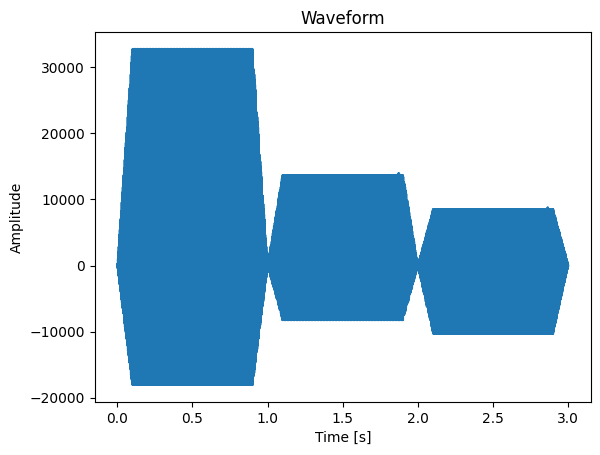

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 波形を取得
base_pulse = song.synthesize()  # shape=(N,)

# サンプリングレートを取得
sr = song.sampling_rate  # たとえば 22050 Hz

# 時間軸を作成
t = np.arange(len(base_pulse)) / sr

# プロット
plt.plot(t, base_pulse)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

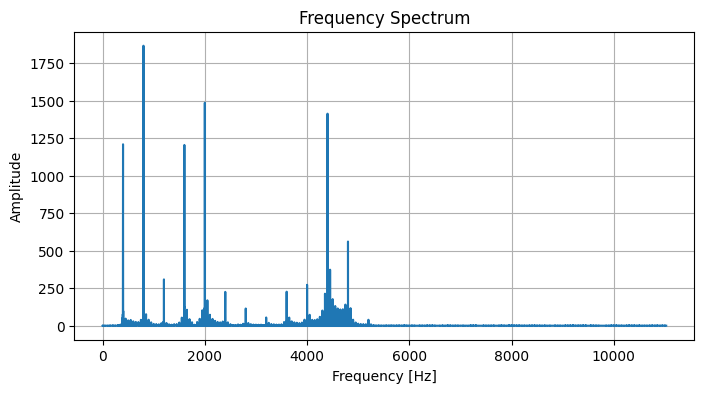

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square

# --- サンプル波形作成 ---
sr = 22050               # サンプリング周波数
wave = song.synthesize()  # 矩形波

# --- FFT ---
N = len(wave)
fft_result = np.fft.fft(wave)
fft_magnitude = np.abs(fft_result) / N  # 正規化
freqs = np.fft.fftfreq(N, 1/sr)        # 周波数軸

# --- 正の周波数だけ表示 ---
mask = freqs >= 0
plt.figure(figsize=(8,4))
plt.plot(freqs[mask], fft_magnitude[mask])
plt.title("Frequency Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()
